In [1]:
%%HTML
<link rel="stylesheet" type="text/css" href="//fonts.googleapis.com/css?family=Quicksand:300" />
<link rel="stylesheet" type="text/css" href="custom.css">

# Hidden Markov Models 

To demonstrate how hidden markov models work, imagine that we have a very y sensor on a robot (dangerbot-9000) that is walking around looking for danger. It needs to give a signal when a bad thing is nearby but the signal is soo noisy that it might give a lot of false positives. If we see a spike from our sensor, is this due to noise or due to a state change? 

![](https://upload.wikimedia.org/wikipedia/commons/thumb/8/83/Hmm_temporal_bayesian_net.svg/500px-Hmm_temporal_bayesian_net.svg.png)

In our example, we will see sensor output $y$ over time. This sensor output depends on the `danger` state $x_i$. Sensor output is independant over time given the state $x$ (which we cannot measure) but the state $x$ is not independant over time however. If danger is nearby, it will lurk around for a while. 

Suddenly, even though we have a very noisy sensor, we may be able to filter out some false positives.

## Working out the Example

Let's use this (somewhat silly) example to learn about a cool tool in the python ecosystem: `pomegranate`. It has some of the bayesian algorithms that `sklearn` is missing. 

In [1]:
import numpy as np
import matplotlib.pylab as plt 
%matplotlib inline

from pomegranate import NormalDistribution, HiddenMarkovModel

Let's say that $x=1$ if there is a bad thing nearby. We'll define some probabilities. First we define; 

$$ p(s|x=0) \sim N(0,2) $$ 
$$ p(s|x=1) \sim N(2,3) $$ 

Next we'll define the transition probabilities;

$$ p(s_i | s_{i-1}) $$ 

Then we can define the model with just a little bit of code; 

With these probabilities defined, we will use a HMM to infer $(x_t | s_t)$

In [21]:
dists = [NormalDistribution(0, 2), NormalDistribution(2, 3)]
trans_mat = np.array([[0.99, 0.01],
                      [0.20, 0.80]])
starts = np.array([0.99, 0.01])
model = HiddenMarkovModel.from_matrix(trans_mat, dists, starts)

Next we'll suppose that this is our sensor data.

In [25]:
data = [0, 0, 0, 0, 0, 1, 4, 5, 4, 1, 0, 0, 0]

We can apply the model against this data to label points where we had danger nearby.

In [26]:
model.predict_proba(data)

array([[0.99622598, 0.00377402],
       [0.99105548, 0.00894452],
       [0.98055079, 0.01944921],
       [0.95671182, 0.04328818],
       [0.90138345, 0.09861655],
       [0.77242904, 0.22757096],
       [0.54895288, 0.45104712],
       [0.48715764, 0.51284236],
       [0.54416189, 0.45583811],
       [0.7539322 , 0.2460678 ],
       [0.8745462 , 0.1254538 ],
       [0.92507851, 0.07492149],
       [0.9440132 , 0.0559868 ]])

In [27]:
model.predict(data)

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

# Exercise 1 

Take this code and play with it. Try to see what happens if: 

- the two output distributions are very much alike 
- the sensor input doesn't have consecutive high values 
- the transition probabilities are very homogenous 

## Fancy Notes 

Note that pomegrenate is flexible. We aren't limited to mere normal distributions. Let's use the poisson distribution now instead.


In [29]:
from pomegranate import PoissonDistribution

Let's come up with another usecase to demonstrate that this functionality of pomegrenate. Granted, it'll be silly, but it'll serve the purpose of explaining.

### GDD Foodtruck

Let's pretend that we have a foodtruck that can be in two states: `grill-on` and `grill-off`. 

If the grill is on, more people will drop by to have a look at what is cooking. If the grill is off, less people will drop by. The problem is that people might drop by due to chance. We know that if the grill is on, we tend to see 3 people drop by every minute while if the grill is off we tend to see 1 person every minute. 

We're using a deep learning algorithm that detects the number of people, so the sensor might be biased a bit too. Can we use hidden markov models to help us? 

### Application 

The example is silly, but it helps explore different distributions in the api.

In [30]:
dists = [PoissonDistribution(1), PoissonDistribution(4)]
trans_mat = np.array([[0.9, 0.1],
                      [0.2, 0.8]])
starts = np.array([0.5, 0.5])
model = HiddenMarkovModel.from_matrix(trans_mat, dists, starts)

Let's generate some data to see how the model might respond.

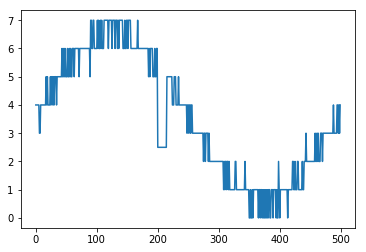

In [32]:
data = 3*np.sin(np.linspace(0, np.pi*2, 500)) 
data += np.random.normal(0, 0.3, data.shape)
data += np.abs(data.min())
data = np.round(data)
data[200:215] = 2.5
plt.plot(data);

This is the, potentially noisy, signal that comes in. Note that we only supply positive values since the poisson distribution doesn't handle negative numbers.

So given the noisy signal of number of people, can we estimate when the grill as turned on? 

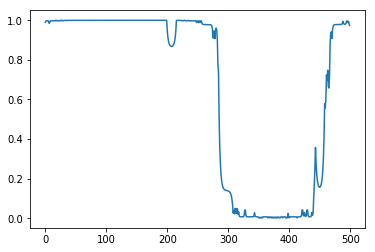

In [34]:
probs = model.predict_proba(data)
plt.plot(probs[:, 1])

The hidden markov model seems to be able to filter out some of the noise. You can also see that it start doubting around index 200 a little bit, but it doesn't see enough evidence to consider the state to have change. 

In practice this smoothing really depends on the transition matrix, which you may want to consider a hyperparameter during training.

## Final Example: Weather 

Let's come up with something that is a little bit less arbitrary. Let's try to predict the season with just the temperature data. 

We'll import the data first. 

In [1]:
import pandas as pd 

df_weather = pd.read_csv('data/clean_weather.csv')
df_weather = df_weather.iloc[365*3:365*10]

def assign_season(dataf):
    return (dataf
            .assign(winter = lambda d: d['month'].isin([1,2,3]))
            .assign(spring = lambda d: d['month'].isin([4,5,6]))
            .assign(summer = lambda d: d['month'].isin([7,8,9]))
            .assign(fall = lambda d: d['month'].isin([10,11,12]))
            .assign(truth = lambda d: np.round((d['month']+1)/3) % 4))

def summarise(dataf):
    return {'nrow': dataf.shape[0]}

We've taken a subset of the temperatures in Eindhoven. You can see the temperatures below.

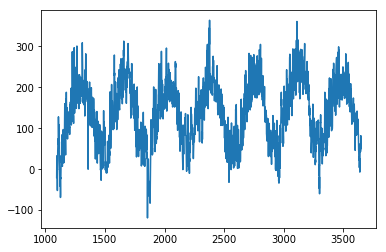

In [36]:
plt.plot(df_weather['max_temp']);

In [37]:
df_weather = df_weather.pipe(assign_season)

After assigning the proper seasons we can see that we get some statistics.

In [38]:
(df_weather
  .groupby(['truth', 'winter', 'spring', 'summer', 'fall'])
  .agg({'max_temp': ['mean', 'std', 'count']})
  .reset_index())

truth winter spring summer   fall    max_temp                 
                                           mean        std count
0   0.0  False  False  False   True  103.183801  48.107237   642
1   1.0   True  False  False  False   64.403481  55.411386   632
2   2.0  False   True  False  False  173.113030  53.658539   637
3   3.0  False  False   True  False  211.246894  40.325922   644

## Exercise 

Use this information to train a hidden markov model in pomegrenate. 

## Answer

Feel free to play with the starter template below.

In [53]:
dists = [NormalDistribution(250, 50), 
         NormalDistribution(250, 50), 
         NormalDistribution(250, 50), 
         NormalDistribution(250, 50)]

trans_mat = np.array([[0.99, 0.01, 0.0, 0.0],
                      [0.0, 0.99, 0.01, 0.0],
                      [0.0, 0.0, 0.99, 0.01],
                      [0.001, 0.0, 0.0, 0.99]])

starts = np.array([0.25, 0.25, 0.25, 0.25])
model = HiddenMarkovModel.from_matrix(trans_mat, dists, starts)

In [54]:
%load ../solutions/06-01-hidden-markov-models-solution.py

With this model defined, lets check out how it works. 

In [55]:
temperatures = df_weather['max_temp'][:365*2]
truth = df_weather['truth'][:365*2]

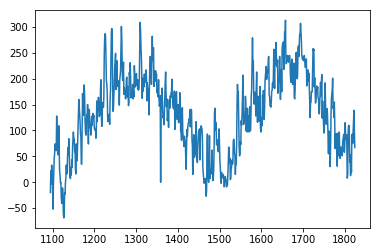

In [56]:
plt.plot(temperatures)

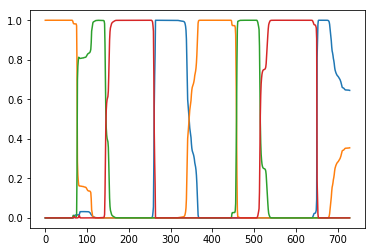

In [57]:
probs = model.predict_proba(temperatures)
for i in range(probs.shape[1]):
    plt.plot(probs[:, i])

So whats so special about this? It still looks like the performance isn't that great. 

Well, imagine the model performance without the time component. 

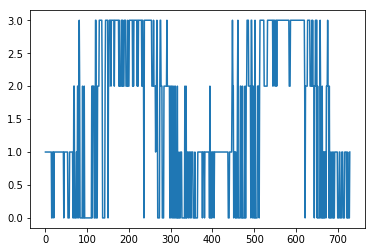

In [58]:
def best_naive(temp, verbose=False):
    if verbose:
        print(temp, [_.log_probability(temp) for _ in dists])
    return np.argmax([_.log_probability(temp) for _ in dists])

naive_pred = [best_naive(t) for t in temperatures]
plt.plot(naive_pred)

Suddenly, when we compare the difference, it becomes better.

In [59]:
np.mean(np.round(naive_pred) == truth), np.mean(model.predict(temperatures) == truth)

(0.547945205479452, 0.8191780821917808)

By using the ordering as a feature in our model, suddenly we jumpy from a 55% accuracy to a 0.82 percent accuracy. Nice! 

# Final Observations 

- Part of the power from the algorithm comes from tuning the transition matrix. Since I know that seasons only switch once a year I've made sure that the transition probability is very low. See what happens if you turn this all the way down.

- Note that typically you can combine the knowledge from multiple algorithms. The markov model might just be a part in an ensemble model. 